In [2]:
# import the dataset

from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [0]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [0]:
from keras import models
from keras import layers

# Define the structure of the model

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # mean square error is our loss and mean absolute error is our metric
    # Compile the model, configure the optimizer
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [7]:
import numpy as np

# K-fold validation

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
# mean average errors on validation set across all the 100 epochs
all_scores

[1.9147737521936399, 2.225191602612486, 2.435041609376964, 2.593382201572456]

In [9]:
# mean 
np.mean(all_scores)

2.2920972914388864

In [10]:
# Saving the validation logs at each fold
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
# compute the average of the per-epoch MAE scores for all folds
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

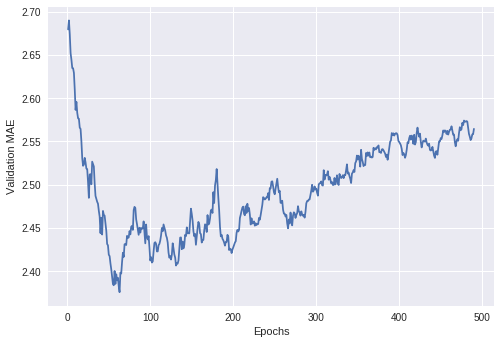

In [12]:
import matplotlib.pyplot as plt

# Plotting Validation MAE by epoch, excluding the first 10 data points (using the moving average)

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [19]:
# According the the graph (Figure 5), validation MAE stops improving significantly after 80 epochs.
# so lets train the model for 80 epochs
model = build_model()

# Training the final model
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


Epoch 1/80
404/404 [==============================] - 1s 2ms/step - loss: 427.1406 - mean_absolute_error: 18.5304
Epoch 2/80
404/404 [==============================] - 0s 90us/step - loss: 89.3667 - mean_absolute_error: 7.2182
Epoch 3/80
404/404 [==============================] - 0s 89us/step - loss: 36.8041 - mean_absolute_error: 4.2806
Epoch 4/80
404/404 [==============================] - 0s 90us/step - loss: 24.7105 - mean_absolute_error: 3.4938
Epoch 5/80
404/404 [==============================] - 0s 87us/step - loss: 19.7016 - mean_absolute_error: 3.1427
Epoch 6/80
404/404 [==============================] - 0s 92us/step - loss: 16.6743 - mean_absolute_error: 2.9029
Epoch 7/80
404/404 [==============================] - 0s 90us/step - loss: 14.3794 - mean_absolute_error: 2.7249
Epoch 8/80
404/404 [==============================] - 0s 86us/step - loss: 13.2157 - mean_absolute_error: 2.5779
Epoch 9/80
404/404 [==============================] - 0s 89us/step - loss: 12.1969 - mean_absol

In [20]:
# Test mean square error
test_mse_score

15.629331850538067

In [21]:
# Test mean absolute error
test_mae_score

2.5181972279268154